# Computer Vision, Dr. Aygul Zagidullina, Dr. Dimitris Mousadakos

# Intuitions on Convolutions

Let's build some intuitions about the **`convolution operations`**.

🎯 <b><u>Goals</u>:</b>
- **Understand convolution operations**
- **Visualize**
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

🖼 <b><u>Convolutional Neural Networks are Neural Networks specifically designed to work on images</u></b>.

- 🧮 This is made possible thanks to **`convolution operations`**.

- 🔎 These specific mathematical operations apply a **`filter`** (i.e. a set of **`kernels`**, one per channel) to an input image and create an **`output representation`**. For Convolutional Neural Networks, this can also be called:
    * a **`"convoluted representation/feature"`**,
    * or a **`"convolution"`**,
    * or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/CNN/convolution.png" width="300">

---

❗️ <b><u>Remarks</u></b> ❗️

* It is important to understand that **the same kernel (i.e. the same weights) is applied to different areas of the images**.

* This is completely different from Dense Neural Networks:
    * In `Dense/"Fully Connected" Neural Networks`, each weight of a given neuron is related to only one input coordinate (which, in images, would correspond to one pixel).
    * In `Convolution Neural Networks`, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step"!

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture to understand the whole picture that is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

🧑🏻‍🏫 It is possible to **retrieve the values of all the kernels for each layer after training a CNN**.

👉 Let's focus first on the different parameters (**`.weights`**) of the first convolutional layer.

In [46]:
# 1. Access the first convolutional layer by its attribute name
first_conv_layer = model.conv1
print(f"First layer object: {first_conv_layer}\n")

First layer object: Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))



In [47]:
# 2. Access the kernels (weights) and their shape
kernels = first_conv_layer.weight
print(f"Kernels tensor shape: {kernels.shape}")

Kernels tensor shape: torch.Size([16, 1, 4, 4])


In [81]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchsummary import summary

In [72]:
# Set device (GPU/MPS/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [73]:
# --- 1. UTILS: Helper Functions (Run this first) ---

def load_data(path):
    """Loads triangle and circle images from a directory."""
    # Note: Ensure you unzip the dataset first!
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist. Please download/unzip data first.")
        return np.array([]), np.array([])
        
    nb_circles = 100
    nb_triangles = 100
    X, y = [], []

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        if os.path.exists(c_path):
            img = np.array(Image.open(c_path))[:, :, :1] # Keep only 1 channel
            X.append(img)
            y.append(0)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        if os.path.exists(t_path):
            img = np.array(Image.open(t_path))[:, :, :1]
            X.append(img)
            y.append(1)

    # Shuffle
    if len(X) > 0:
        c = list(zip(X, y))
        np.random.shuffle(c)
        X, y = zip(*c)
        
    return np.array(X), np.array(y)

def show_sample_images(X, y, num_images=5):
    """Displays a row of sample images with their labels."""
    if len(X) == 0: return
    plt.figure(figsize=(15, 5))
    for i in range(min(len(X), num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i][:, :, 0], cmap='gray')
        label = 'Triangle' if y[i] == 1 else 'Circle'
        plt.title(f"{label}")
        plt.axis('off')
    plt.show()

def compute_convolution(input_image, kernel):
    """Manual 2D convolution for visualization purposes."""
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape
    img = np.squeeze(input_image)
    img_height, img_width = img.shape
    
    output_image = []
    for x in range(img_height - kernel_height + 1):
        arr = []
        for y in range(img_width - kernel_width + 1):
            image_patch = img[x: x + kernel_height, y: y + kernel_width]
            # Element-wise multiply and sum
            convolved_value = np.multiply(image_patch, kernel).sum()
            arr.append(convolved_value)
        output_image.append(arr)
    return np.array(output_image)

class EarlyStopper:
    """Early stopping utility to stop training when validation loss stops decreasing."""
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"INFO: Early stopping triggered after {self.patience} epochs.")
                self.early_stop = True

In [74]:
def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    """
    Standard PyTorch training loop with validation and early stopping.
    """
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    early_stopper = EarlyStopper(patience=patience)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print("Starting training...")
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Stats
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_train_acc = correct_train / total_train
        epoch_val_acc = correct_val / total_val

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # Early Stopping
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            break

    # Load best weights
    if early_stopper.best_model_state:
        print("Loading best model weights.")
        model.load_state_dict(early_stopper.best_model_state)
        
    return history

In [75]:
def plot_history(history):
    """Plots loss and accuracy curves."""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax[0].plot(history['train_loss'], label='Train')
    ax[0].plot(history['val_loss'], label='Validation')
    ax[0].set_title('Model Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True, linewidth=0.5)

    # Accuracy
    ax[1].plot(history['train_acc'], label='Train')
    ax[1].plot(history['val_acc'], label='Validation')
    ax[1].set_title('Model Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, linewidth=0.5)
    plt.show()

def visualize_layer_kernels(layer, input_image):
    """Plots the effect of all kernels from a specific Conv2d layer on an image."""
    weights = layer.weight.detach().cpu().numpy()
    num_kernels = weights.shape[0]
    
    # Ensure input image is 2D numpy
    if isinstance(input_image, torch.Tensor):
        input_image = input_image.cpu().numpy()
    if input_image.ndim == 3:
        input_image = input_image.squeeze()

    print(f"Visualizing {num_kernels} kernels...")
    
    cols = 4
    rows = math.ceil(num_kernels / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    fig.suptitle("Effect of Kernels (Activation=True)", y=1.02)
    
    axes = np.array(axes).flatten() # Flatten in case rows=1
    
    for i, ax in enumerate(axes):
        if i < num_kernels:
            # Get kernel for 1st input channel
            kernel = weights[i, 0, :, :] 
            
            # Manual convolution + ReLU for visualization
            output = compute_convolution(input_image, kernel) 
            output = np.maximum(output, 0) 
            
            ax.imshow(output, cmap='gray')
            ax.set_title(f"Kernel {i}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_activations(model, input_tensor):
    """Hooks into model to capture and plot feature maps for all Conv layers."""
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(get_activation(name)))

    # Forward pass
    model.eval()
    input_tensor = input_tensor.to(device)
    if input_tensor.dim() == 3: input_tensor = input_tensor.unsqueeze(0)
    
    with torch.no_grad():
        _ = model(input_tensor)

    # Plot
    for layer_name, acts in activations.items():
        num_maps = acts.shape[1]
        grid_size = math.ceil(math.sqrt(num_maps))
        
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle(f'Activations of {layer_name}', y=1.02)
        
        # Flatten axes array for easy iteration
        axes = np.array(axes).flatten() 

        for i, ax in enumerate(axes):
            if i < num_maps:
                # [0, i, :, :] gets i-th map of batch 0
                fmap = acts[0, i, :, :].cpu().numpy()
                ax.imshow(fmap, cmap='gray')
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Cleanup hooks
    for h in hooks: h.remove()

In [82]:
def visualize_convolution_operation(image, kernel, title=""):
    """
    Visualizes the Input Image, The Kernel (Filter), and the Convolved Output side-by-side.
    """
    # 1. Perform Manual Convolution
    output = compute_convolution(image, kernel)
    
    # 2. Setup Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    if title: fig.suptitle(title, fontsize=16)

    # --- Panel 1: Input Image ---
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Input Image ({image.shape[0]}x{image.shape[1]})")
    axes[0].axis('off')

    # --- Panel 2: The Kernel (Heatmap) ---
    # We use a heatmap so students can see the values (positive/negative)
    sns.heatmap(kernel, annot=True, fmt=".1f", cmap="coolwarm", cbar=False, 
                ax=axes[1], square=True, linewidths=1, linecolor='black')
    axes[1].set_title(f"The Kernel ({kernel.shape[0]}x{kernel.shape[1]})")
    
    # --- Panel 3: Output Image ---
    # We use 'ReLU' visualization (clip negatives) to match what the network 'sees'
    output_relu = np.maximum(output, 0)
    axes[2].imshow(output_relu, cmap='gray')
    axes[2].set_title(f"Output Feature Map ({output.shape[0]}x{output.shape[1]})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

## 2. Load and Inspect Dat

Data Loaded: 200 images
Shape: (200, 76, 78, 1)
Min value: 0, Max value: 255


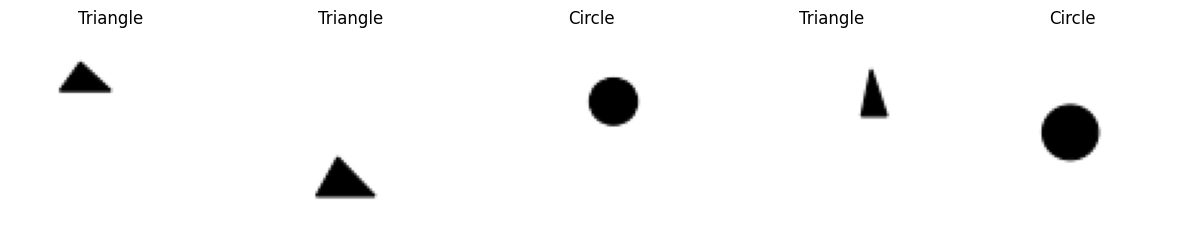

In [76]:
# Download dataset
# !unzip -q circles-and-triangles.zip

X, y = load_data("data")

print(f"Data Loaded: {len(X)} images")
print(f"Shape: {X.shape}") # (200, 76, 78, 1)

# Check normalization necessity
print(f"Min value: {np.min(X)}, Max value: {np.max(X)}") 
# Since max is 255, we usually normalize in the Tensor conversion step or manually.
# For simplicity, we will normalize manually here.
X = X / 255.0

show_sample_images(X, y)

In [12]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''

    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')

    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')

    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.show()

❓ **Question** ❓ Apply `plot_convolution` with the following `kernel_1` once on an triangle and once on a circle.


In [13]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

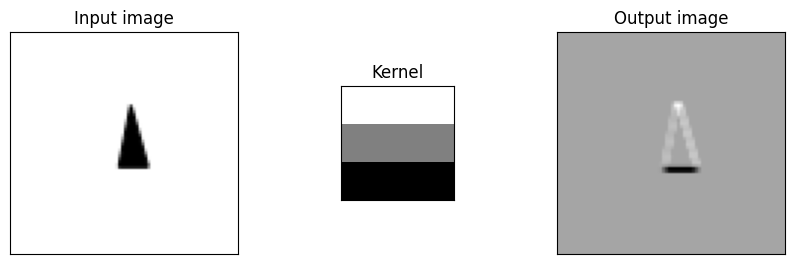

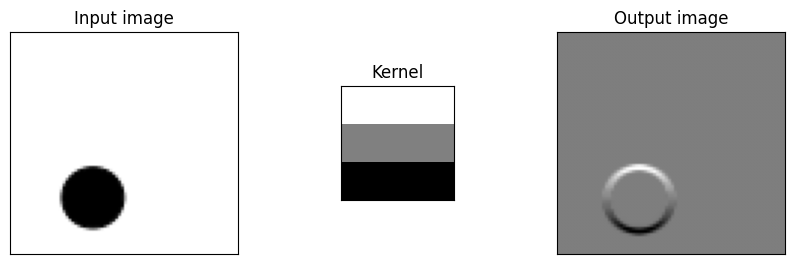

In [14]:
plot_convolution(X[0], kernel_1)
plot_convolution(X[5], kernel_1)

👆 Let's analyze what just happened:

* White pixels correspond to high values and black pixels to low values.
* In a Neural Network, remember that we use activation functions to remove linearities.
    * *For example*, when the activation function is `relu`, you already know that it simply corresponds to setting the negative values to 0.

---

❓ **What is the impact of the activation function in a Convolutional Layer ?** ❓

Re-run the previous function `plot_convolution` with `activation` set to `True` (in this case, the activation function _is_ the relu).

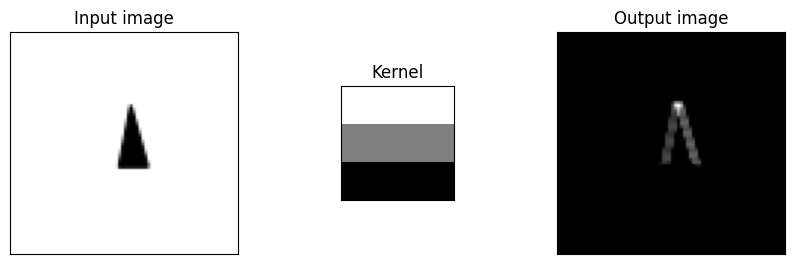

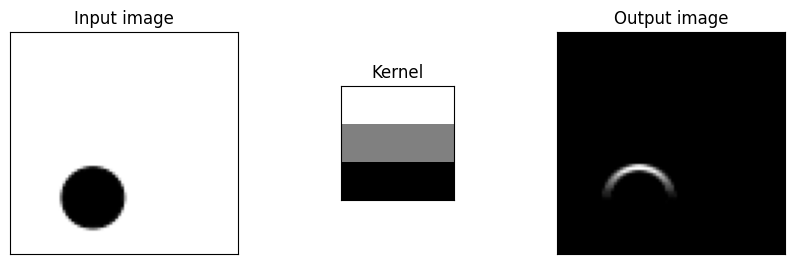

In [15]:
plot_convolution(X[0], kernel_1, activation=True)
plot_convolution(X[5], kernel_1, activation=True)

👆 This kernel is actually highlighting the edges in a given direction.

❓ **Play with different kernels...** ❓

Try the following kernels to check the different edges they can detect.

In [16]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

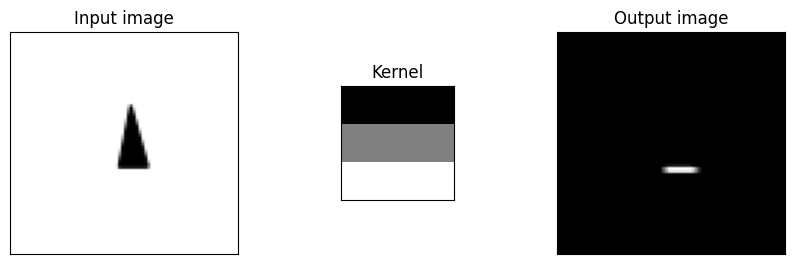

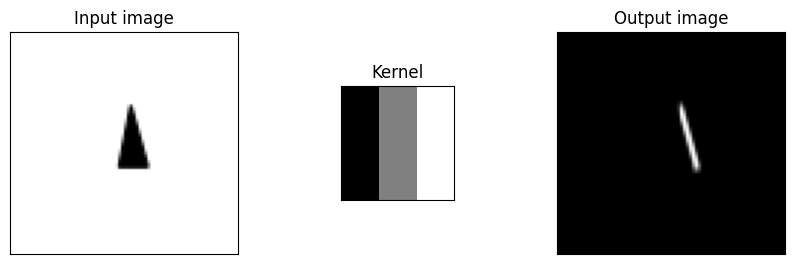

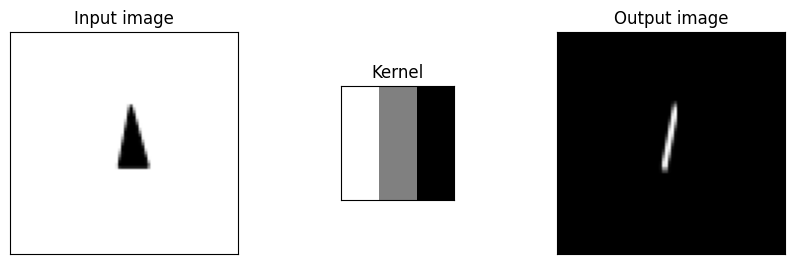

In [17]:
plot_convolution(X[0], kernel_2, activation=True)
plot_convolution(X[0], kernel_3, activation=True)
plot_convolution(X[0], kernel_4, activation=True)

❓ **What is the effect of the kernel size** ❓

Try the _kernel_big_.

In [18]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

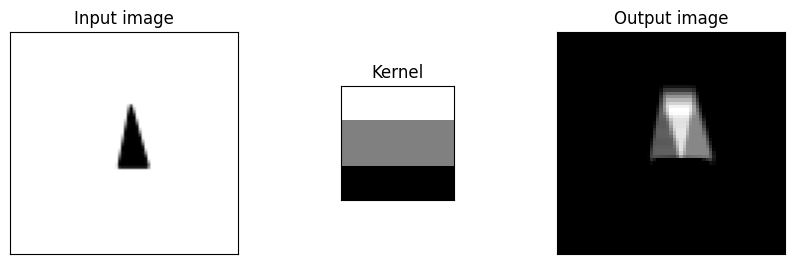

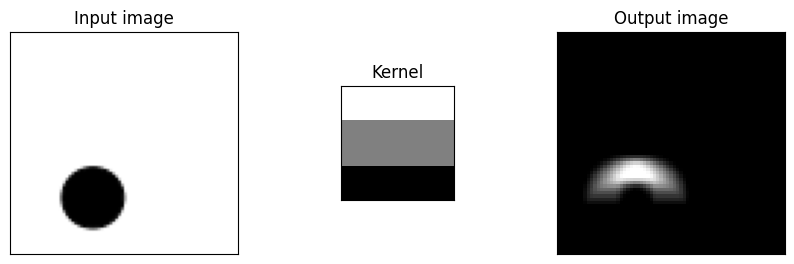

In [19]:

plot_convolution(X[0], kernel_big, activation=True)
plot_convolution(X[5], kernel_big, activation=True)


❓ **Try another kernel**  ❓

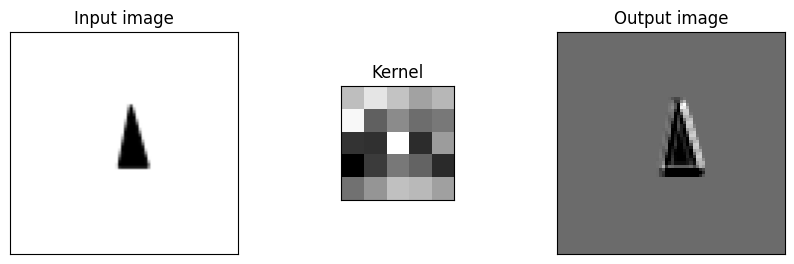

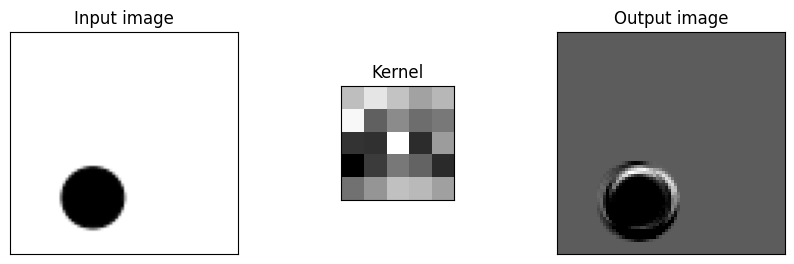

In [20]:
random_kernel = np.random.uniform(-10, 10, (5, 5))

plot_convolution(X[0], random_kernel, activation=True)
plot_convolution(X[5], random_kernel, activation=True)


Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network. ✅

## Training a CNN to detect triangles and circles

### Architecture


❓ **Question: Designing a CNN** ❓

- a Convolutional Layer with 16 filters with $ (4, 4) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 64 filters with $ (2, 2) $ kernels.

with:
- A Max-Pooling Layer (with a $ (2, 2) $ pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part
    - but before the last layer


Also, make sure to compile your model with the appropriate parameters

In [77]:
# --- 3. Define the CNN Architecture ---

class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(4, 4))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Block 4
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Dense Layers
        # Input features calculation: 
        # (76,78) -> (73,75)/2 -> (36,37) -> (34,35)/2 -> (17,17) -> (15,15)/2 -> (7,7) -> (6,6)/2 -> (3,3)
        # 64 channels * 3 * 3 = 576
        self.fc1 = nn.Linear(576, 10)
        self.fc2 = nn.Linear(10, 1) # Binary output

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = x.view(-1, 576) # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = PyTorchCNN()
summary(model, input_size=(1, 76, 78))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 73, 75]             272
         MaxPool2d-2           [-1, 16, 36, 37]               0
            Conv2d-3           [-1, 32, 34, 35]           4,640
         MaxPool2d-4           [-1, 32, 17, 17]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 6, 6]          16,448
         MaxPool2d-8             [-1, 64, 3, 3]               0
            Linear-9                   [-1, 10]           5,770
           Linear-10                    [-1, 1]              11
Total params: 45,637
Trainable params: 45,637
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.35
Params size (MB): 0.17
Estimated Tot

👆 `torch.Size([16, 1, 4, 4])` represents:
- the weights of each kernel (size `4` $\times$ `4`)
- there was only `1` channel (single B&W input)
- and we have decided to apply `16` different kernels in this layer!

### **Model Architecture Breakdown**

**1. `Conv2d-1: [-1, 16, 73, 75]` (272 params)**
* **What:** The first convolutional layer.
* **Input:** Receives the original grayscale image (1 channel).
* **Filters:** Applies **16 filters** (kernels) of size $4 \times 4$.
* **Shape:** The image size shrinks slightly (76x78 $\to$ 73x75) because we are not using padding.
* **Params:** $(1 \text{ input} \times 16 \text{ output} \times 4 \times 4) + 16 \text{ biases} = 272$.

**2. `MaxPool2d-2: [-1, 16, 36, 37]` (0 params)**
* **What:** The first downsampling operation.
* **Action:** It looks at $2 \times 2$ windows and keeps the biggest number.
* **Shape:** The height and width are roughly cut in half ($73/2 \approx 36$).

**3. `Conv2d-3: [-1, 32, 34, 35]` (4,640 params)**
* **What:** The second convolutional layer.
* **Filters:** Applies **32 filters** of size $3 \times 3$.
* **Shape:** Reduces dimensions by 2 pixels ($36 \to 34$) due to the $3 \times 3$ kernel without padding.
* **Params:** $(16 \text{ input} \times 32 \text{ output} \times 3 \times 3) + 32 \text{ biases} = 4,640$.

**4. `MaxPool2d-4: [-1, 32, 17, 17]` (0 params)**
* **What:** Second downsampling.
* **Shape:** Halves the dimensions again ($34/2 = 17$).

**5. `Conv2d-5: [-1, 64, 15, 15]` (18,496 params)**
* **What:** The third convolutional layer.
* **Filters:** Applies **64 filters** of size $3 \times 3$.
* **Shape:** Reduces dimensions by 2 pixels ($17 \to 15$).
* **Params:** $(32 \text{ input} \times 64 \text{ output} \times 3 \times 3) + 64 \text{ biases} = 18,496$.

**6. `MaxPool2d-6: [-1, 64, 7, 7]` (0 params)**
* **What:** Third downsampling.
* **Shape:** Halves the dimensions ($15/2 = 7.5 \to 7$).

**7. `Conv2d-7: [-1, 64, 6, 6]` (16,448 params)**
* **What:** The fourth convolutional layer.
* **Filters:** Applies **64 filters** of size $2 \times 2$.
* **Shape:** Reduces dimensions by 1 pixel ($7 \to 6$) due to the $2 \times 2$ kernel.
* **Params:** $(64 \text{ input} \times 64 \text{ output} \times 2 \times 2) + 64 \text{ biases} = 16,448$.

**8. `MaxPool2d-8: [-1, 64, 3, 3]` (0 params)**
* **What:** Final downsampling.
* **Shape:** Halves dimensions to the final grid size of **3x3**.
* **Crucial Step:** At this point, the data is a 3D block: **64 channels x 3 height x 3 width**. Before the next layer, this is flattened into a single list of $64 \times 3 \times 3 = \mathbf{576}$ numbers.

**9. `Linear-9: [-1, 10]` (5,770 params)**
* **What:** A dense (fully connected) layer.
* **Action:** Compresses the 576 flattened features into 10 summary features.
* **Params:** $(576 \text{ inputs} \times 10 \text{ neurons}) + 10 \text{ biases} = 5,770$.

**10. `Linear-10: [-1, 1]` (11 params)**
* **What:** The output layer.
* **Action:** Reduces the 10 features to a single prediction score.
* **Params:** $(10 \text{ inputs} \times 1 \text{ neuron}) + 1 \text{ bias} = 11$.

## 4. Training

Starting training...
Epoch 1/50 | Loss: 0.6905 | Val Loss: 0.7065 | Acc: 0.5429 | Val Acc: 0.4000
Epoch 2/50 | Loss: 0.6887 | Val Loss: 0.7121 | Acc: 0.5429 | Val Acc: 0.4000
Epoch 3/50 | Loss: 0.6840 | Val Loss: 0.7132 | Acc: 0.5429 | Val Acc: 0.4000
Epoch 4/50 | Loss: 0.6657 | Val Loss: 0.7188 | Acc: 0.5429 | Val Acc: 0.4000
Epoch 5/50 | Loss: 0.6028 | Val Loss: 0.6613 | Acc: 0.5429 | Val Acc: 0.4000
Epoch 6/50 | Loss: 0.4949 | Val Loss: 0.5792 | Acc: 0.5429 | Val Acc: 0.8167
Epoch 7/50 | Loss: 0.4039 | Val Loss: 0.5136 | Acc: 0.9143 | Val Acc: 0.8333
Epoch 8/50 | Loss: 0.2380 | Val Loss: 0.3453 | Acc: 0.9286 | Val Acc: 0.8333
Epoch 9/50 | Loss: 0.1449 | Val Loss: 0.4072 | Acc: 0.9571 | Val Acc: 0.8500
Epoch 10/50 | Loss: 0.1095 | Val Loss: 0.3266 | Acc: 0.9571 | Val Acc: 0.8333
Epoch 11/50 | Loss: 0.0724 | Val Loss: 0.3216 | Acc: 0.9714 | Val Acc: 0.8667
Epoch 12/50 | Loss: 0.0925 | Val Loss: 0.5254 | Acc: 0.9571 | Val Acc: 0.8500
Epoch 13/50 | Loss: 0.1051 | Val Loss: 0.2484 | Acc:

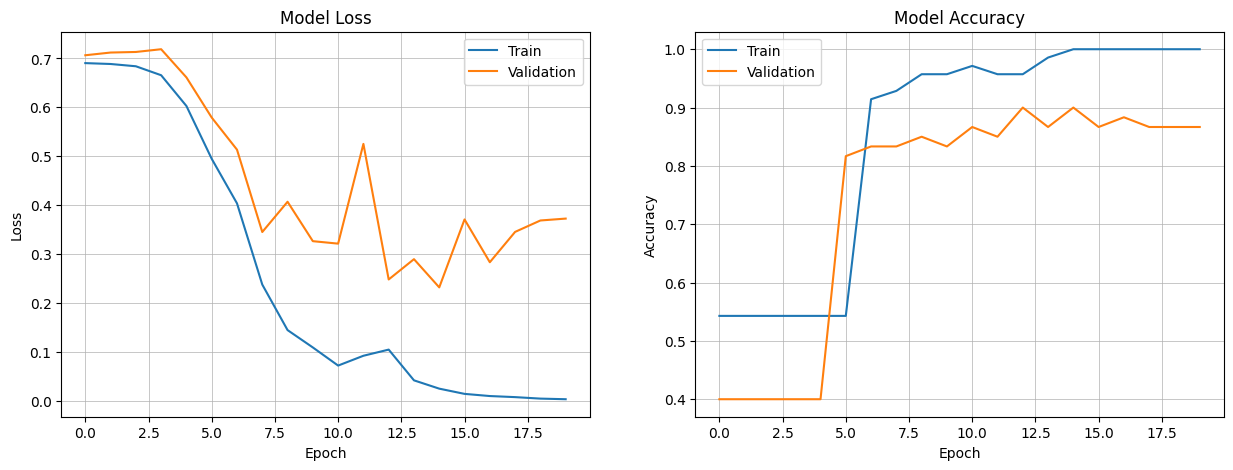

In [78]:
# Prepare Tensors
# PyTorch expects (N, Channels, Height, Width)
X_tensor = torch.from_numpy(X.astype(np.float32)).permute(0, 3, 1, 2)
y_tensor = torch.from_numpy(y.astype(np.float32)).view(-1, 1)

# Dataset & Split
dataset = TensorDataset(X_tensor, y_tensor)
val_size = int(len(dataset) * 0.3)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Run Training
history = train_model(model, train_loader, val_loader, epochs=50)

# Plot Results
plot_history(history)

## Deep Dive: Input vs Kernel vs Output

Visualizing the effect of the first trained filter:


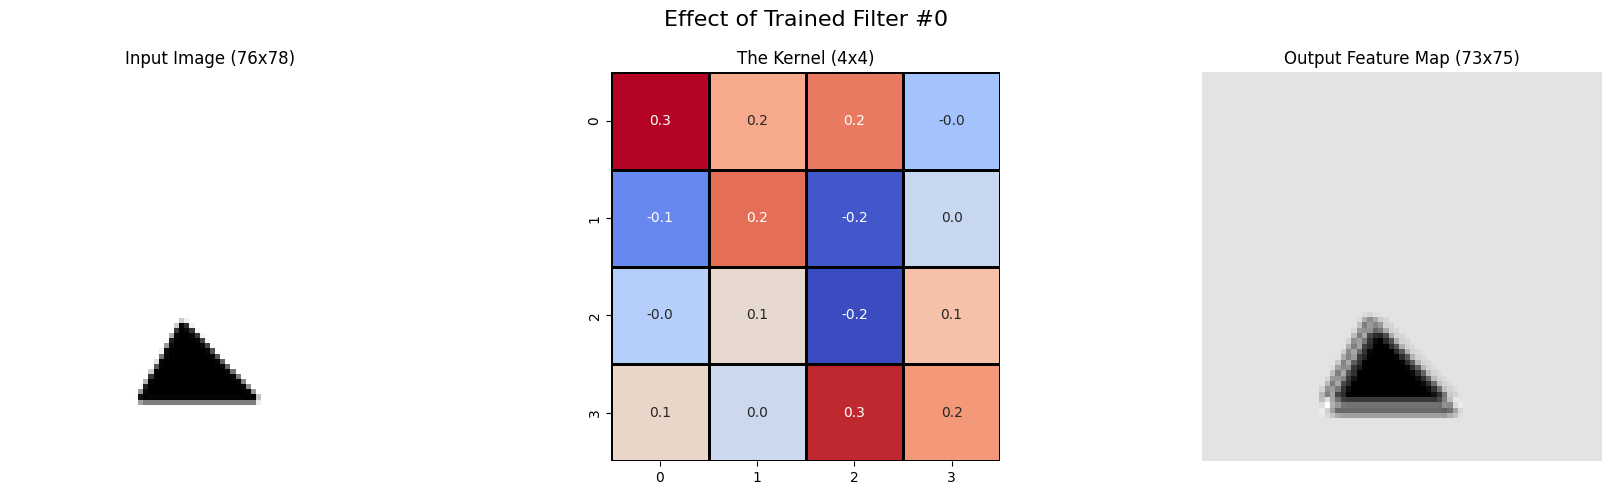


Visualizing a custom Edge Detection kernel:


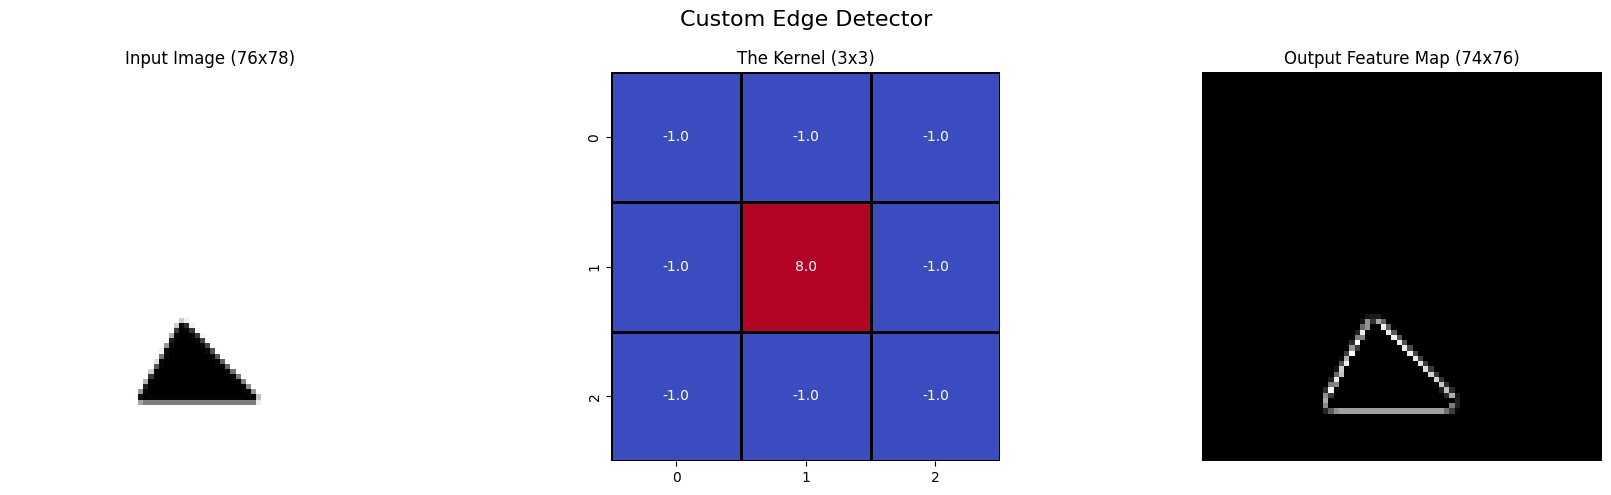

In [83]:

# 1. Select a Sample Image (Triangle)
# Squeeze removes the channel dimension (1, 76, 78) -> (76, 78) for plotting
sample_image = X[1].squeeze() 

# 2. Extract a real kernel from the trained model's first layer
# shape is (16, 1, 4, 4) -> we take the first filter (0) and remove extra dims
trained_kernel = model.conv1.weight.detach().cpu().numpy()[0, 0, :, :]

print("Visualizing the effect of the first trained filter:")
visualize_convolution_operation(sample_image, trained_kernel, title="Effect of Trained Filter #0")

# 3. (Optional) Define a custom edge detection kernel to prove the concept
# This helps students understand that kernels are just pattern matchers
custom_edge_kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

print("\nVisualizing a custom Edge Detection kernel:")
visualize_convolution_operation(sample_image, custom_edge_kernel, title="Custom Edge Detector")

##  Activations 🧨

We have been looking at the activation ("_output image_") only after the **first convolutional layer**.

🤔 What if we want to **visualize the activation of an image after every convolutional layer of the CNN** ?

## 5. Deep Dive: Visualizing Kernels & Activations

Visualizing 16 kernels...


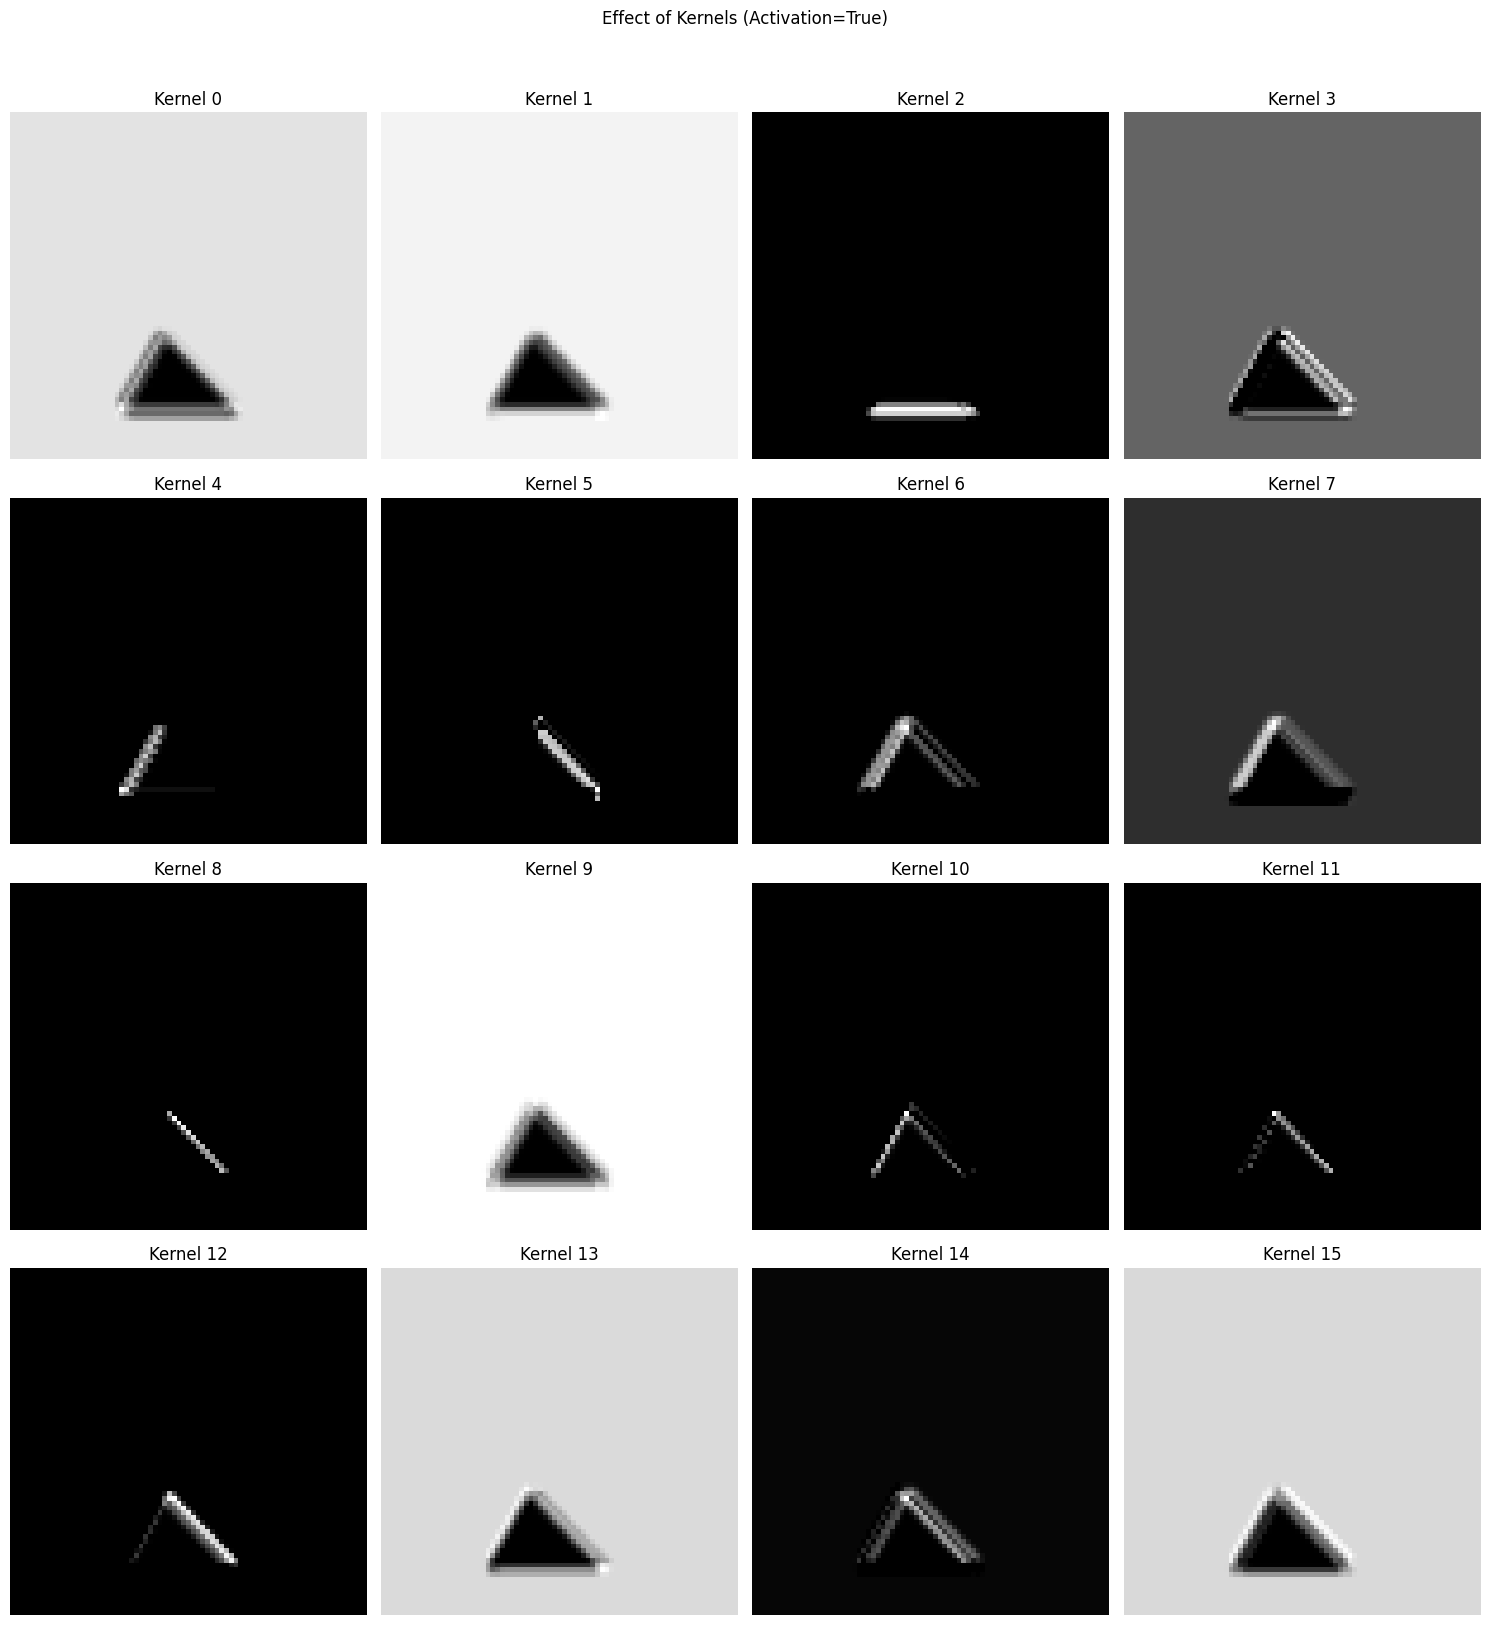

In [79]:
# A. Visualizing what kernels do (using manual convolution on one image)
# We pick one triangle image
test_img = X[1] 

# Visualize kernels from the first layer
visualize_layer_kernels(model.conv1, test_img)

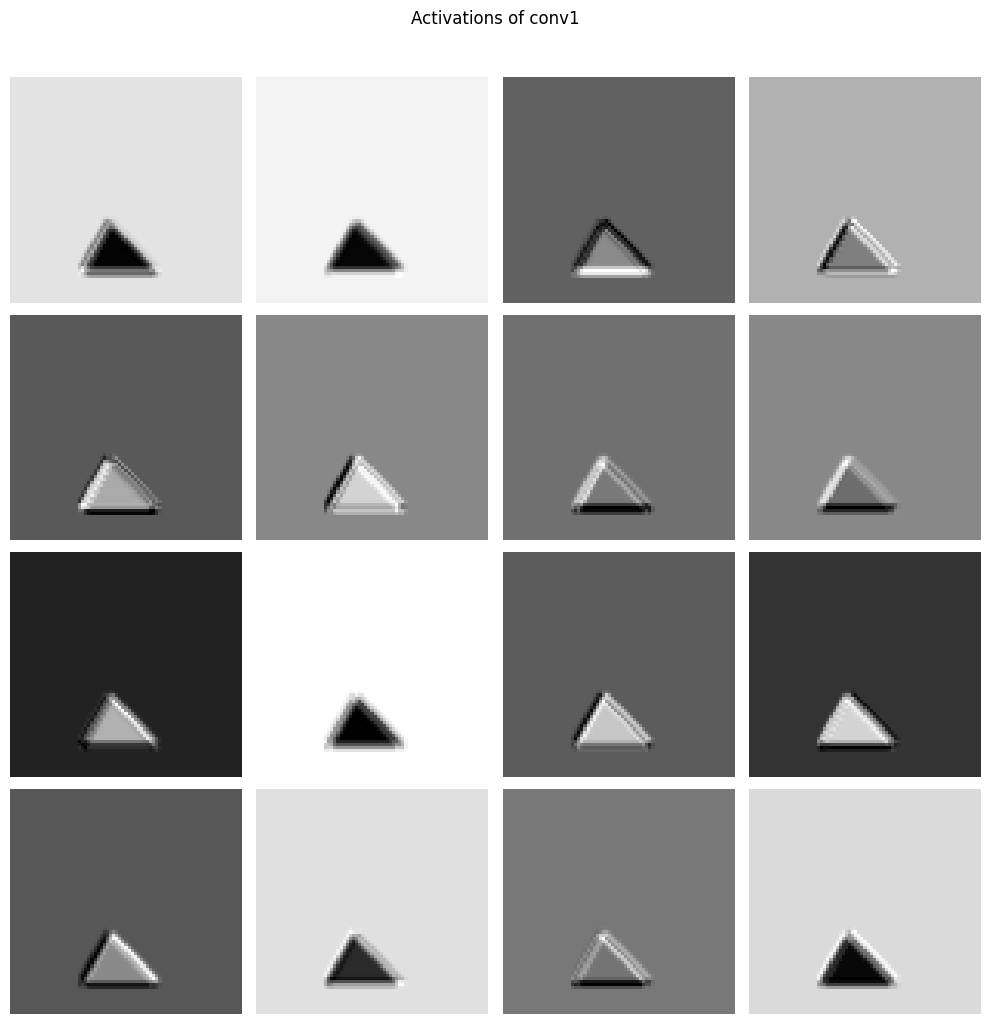

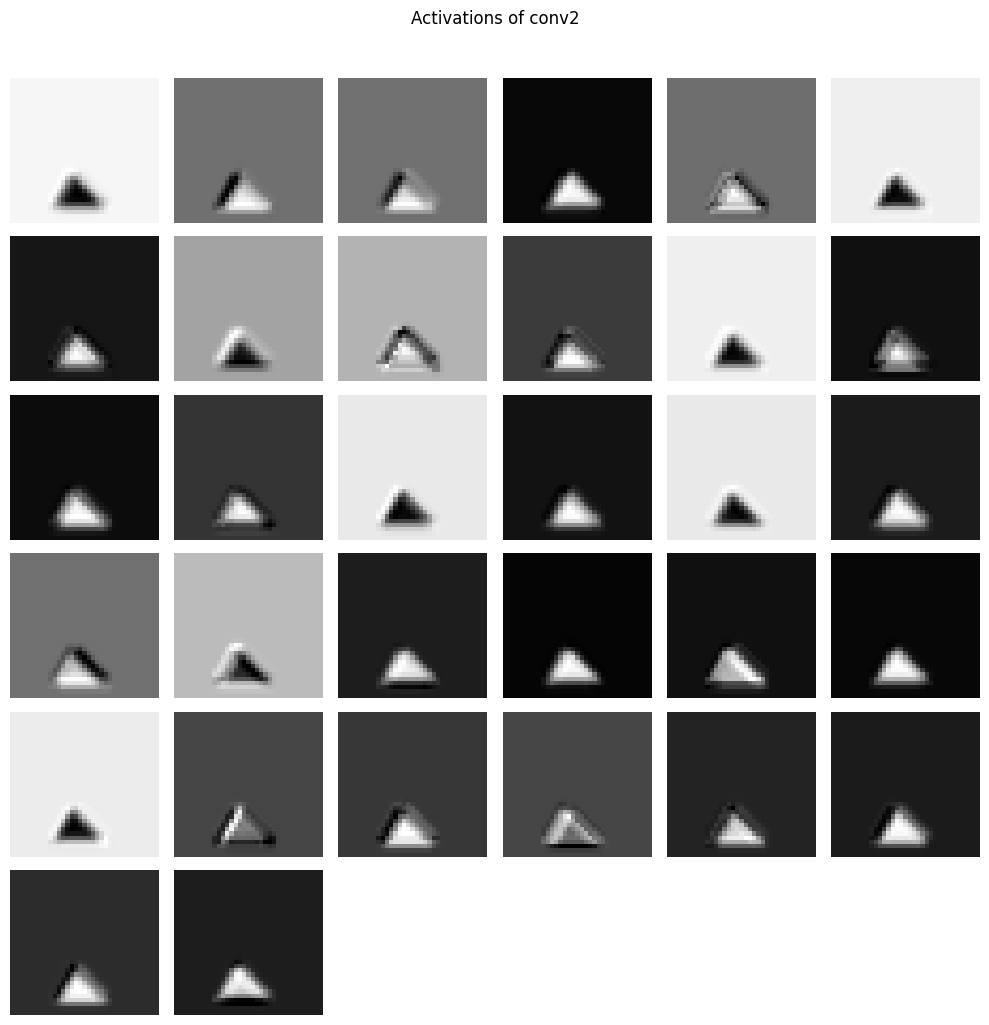

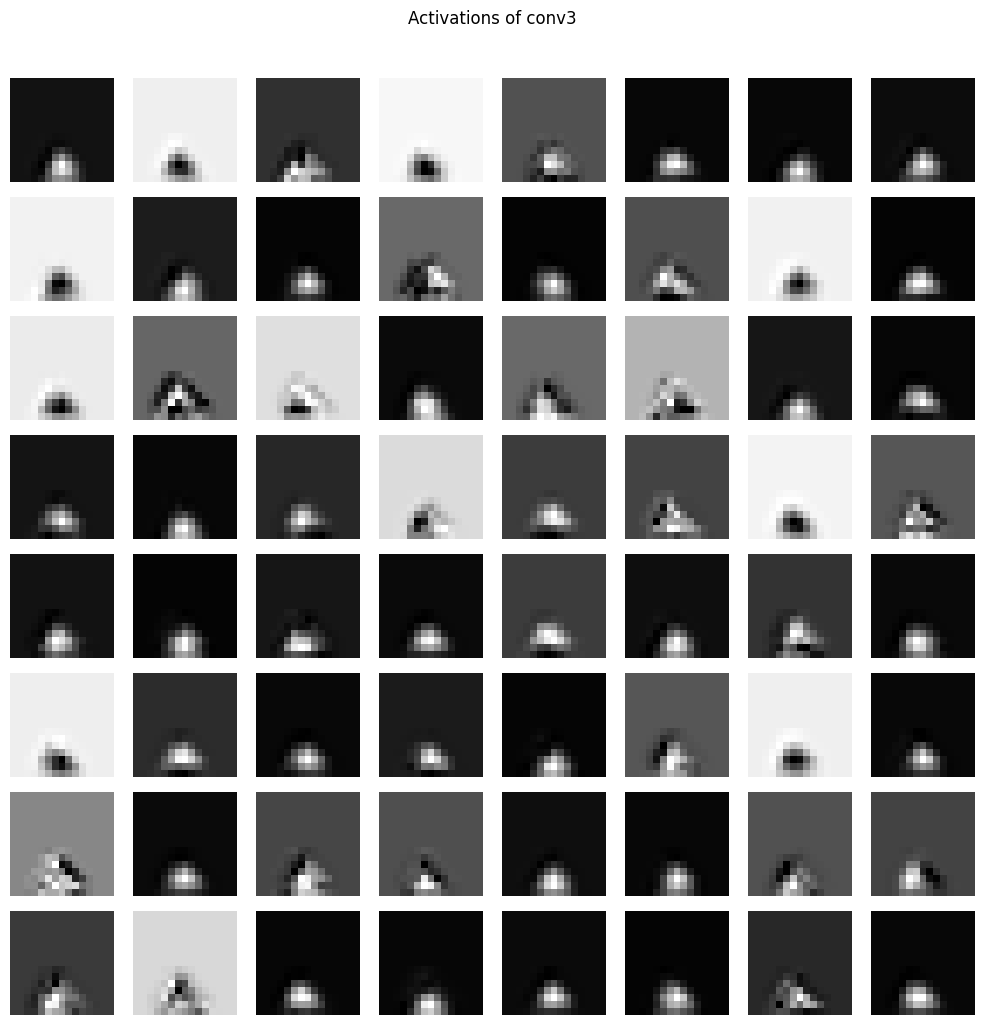

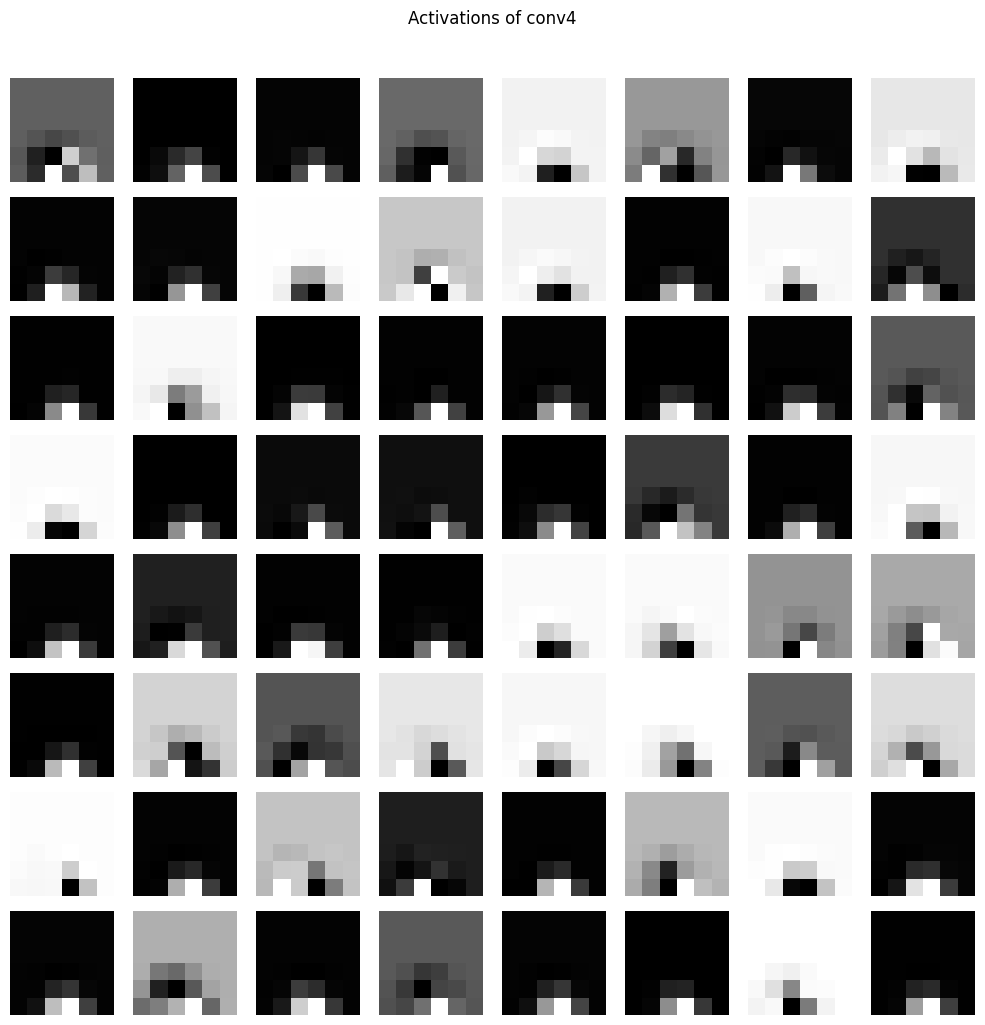

In [80]:
# B. Visualizing Activations (Feature Maps) through the network
# See how the image transforms layer by layer
test_tensor = X_tensor[1]

visualize_activations(model, test_tensor)

🧑🏻‍🏫 ***Notes*** 🧑🏻‍🏫

1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

🕹 Feel free to play with the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) from researchers at [Georgia Tech](https://www.gatech.edu/)

## (Appendix) Utils

* The following section simply presents the functions that were used to create the dataset with triangles and circles.

* They are at the end of the notebook just in case you want to further prototype and get better understanding of what is going on.

In [68]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)

    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)

def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)

def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()


def create_images(path):
    nb_circles = 100
    nb_triangles = 100

    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)

    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)